In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.cluster.hierarchy import dendrogram
import plotly.graph_objects as go

from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import SimpleImputer, IterativeImputer

import random

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import usaddress

# Ouverture et analyses de base

In [2]:
data = pd.read_csv('./data/2016_Building_Energy_Benchmarking.csv')

In [31]:
data.head(15)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,Steam,Electricity,Gas,SimpleAddress
115,183,2016,Nonresidential,Residence hall,Emerson hall,500 w. emerson,Seattle,Wa,98119.0,7443000375,...,False,<NA>,Compliant,<NA>,129.389999,0.93,0,1,1,w emerson
2183,24701,2016,Nonresidential,Other,(id24701) showbox sodo,1700 1st ave s,Seattle,Wa,98134.0,7666206400,...,False,<NA>,Compliant,<NA>,17.450001,0.84,0,1,1,1st ave s
594,796,2016,Nonresidential,Large office,6100 building,6100 4th ave s,Seattle,Wa,98108.0,5367200610,...,False,<NA>,Compliant,<NA>,75.120003,0.32,0,1,0,4th ave s
1369,21647,2016,Multifamily lr (1-4),Low-rise multifamily,Summit view apartments,745 summit ave e,Seattle,Wa,98102.0,2163900350,...,False,<NA>,Compliant,<NA>,4.210000,0.12,0,1,0,summit ave e
629,848,2016,Nonresidential,Retail store,#4706 bitterlake,11616 aurora ave n,Seattle,Wa,98133.0,3026049093,...,False,<NA>,Compliant,<NA>,295.119995,2.90,0,1,1,aurora ave n
1063,20714,2016,Multifamily lr (1-4),Low-rise multifamily,Bancroft,1615 15th ave,Seattle,Wa,98122.0,1728800115,...,False,<NA>,Compliant,<NA>,82.870003,3.34,0,1,1,15th ave
227,351,2016,Nonresidential,Large office,1111 third avenue,1111 3rd ave suite 310,Seattle,Wa,98101.0,0942000050,...,False,<NA>,Compliant,<NA>,231.320007,0.30,0,1,1,3rd ave
3315,50029,2016,Multifamily hr (10+),High-rise multifamily,Walton lofts,75 vine st,Seattle,Wa,98121.0,0653000195,...,False,<NA>,Compliant,<NA>,86.989998,0.70,0,1,1,vine st
1003,20480,2016,Multifamily mr (5-9),Mid-rise multifamily,Lake city house,12546 33rd ave ne,Seattle,Wa,98125.0,1453601041,...,False,<NA>,Compliant,<NA>,69.150002,0.80,0,1,1,33rd ave ne
2780,26919,2016,Multifamily lr (1-4),Low-rise multifamily,Lambda chi alpha,4509 19th ave ne,Seattle,Wa,98105.0,8823902740,...,False,<NA>,Compliant,<NA>,48.450001,2.35,0,1,1,19th ave ne


In [3]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (3376, 46) :



Type des colonnes :
|                                 | 0       |
|:--------------------------------|:--------|
| OSEBuildingID                   | int64   |
| DataYear                        | int64   |
| BuildingType                    | object  |
| PrimaryPropertyType             | object  |
| PropertyName                    | object  |
| Address                         | object  |
| City                            | object  |
| State                           | object  |
| ZipCode                         | float64 |
| TaxParcelIdentificationNumber   | object  |
| CouncilDistrictCode             | int64   |
| Neighborhood                    | object  |
| Latitude                        | float64 |
| Longitude                       | float64 |
| YearBuilt                       | int64   |
| NumberofBuildings               | float64 |
| NumberofFloors                  | int64   |
| PropertyGFATotal                | int64   |
| PropertyGFAParking   

<AxesSubplot: >

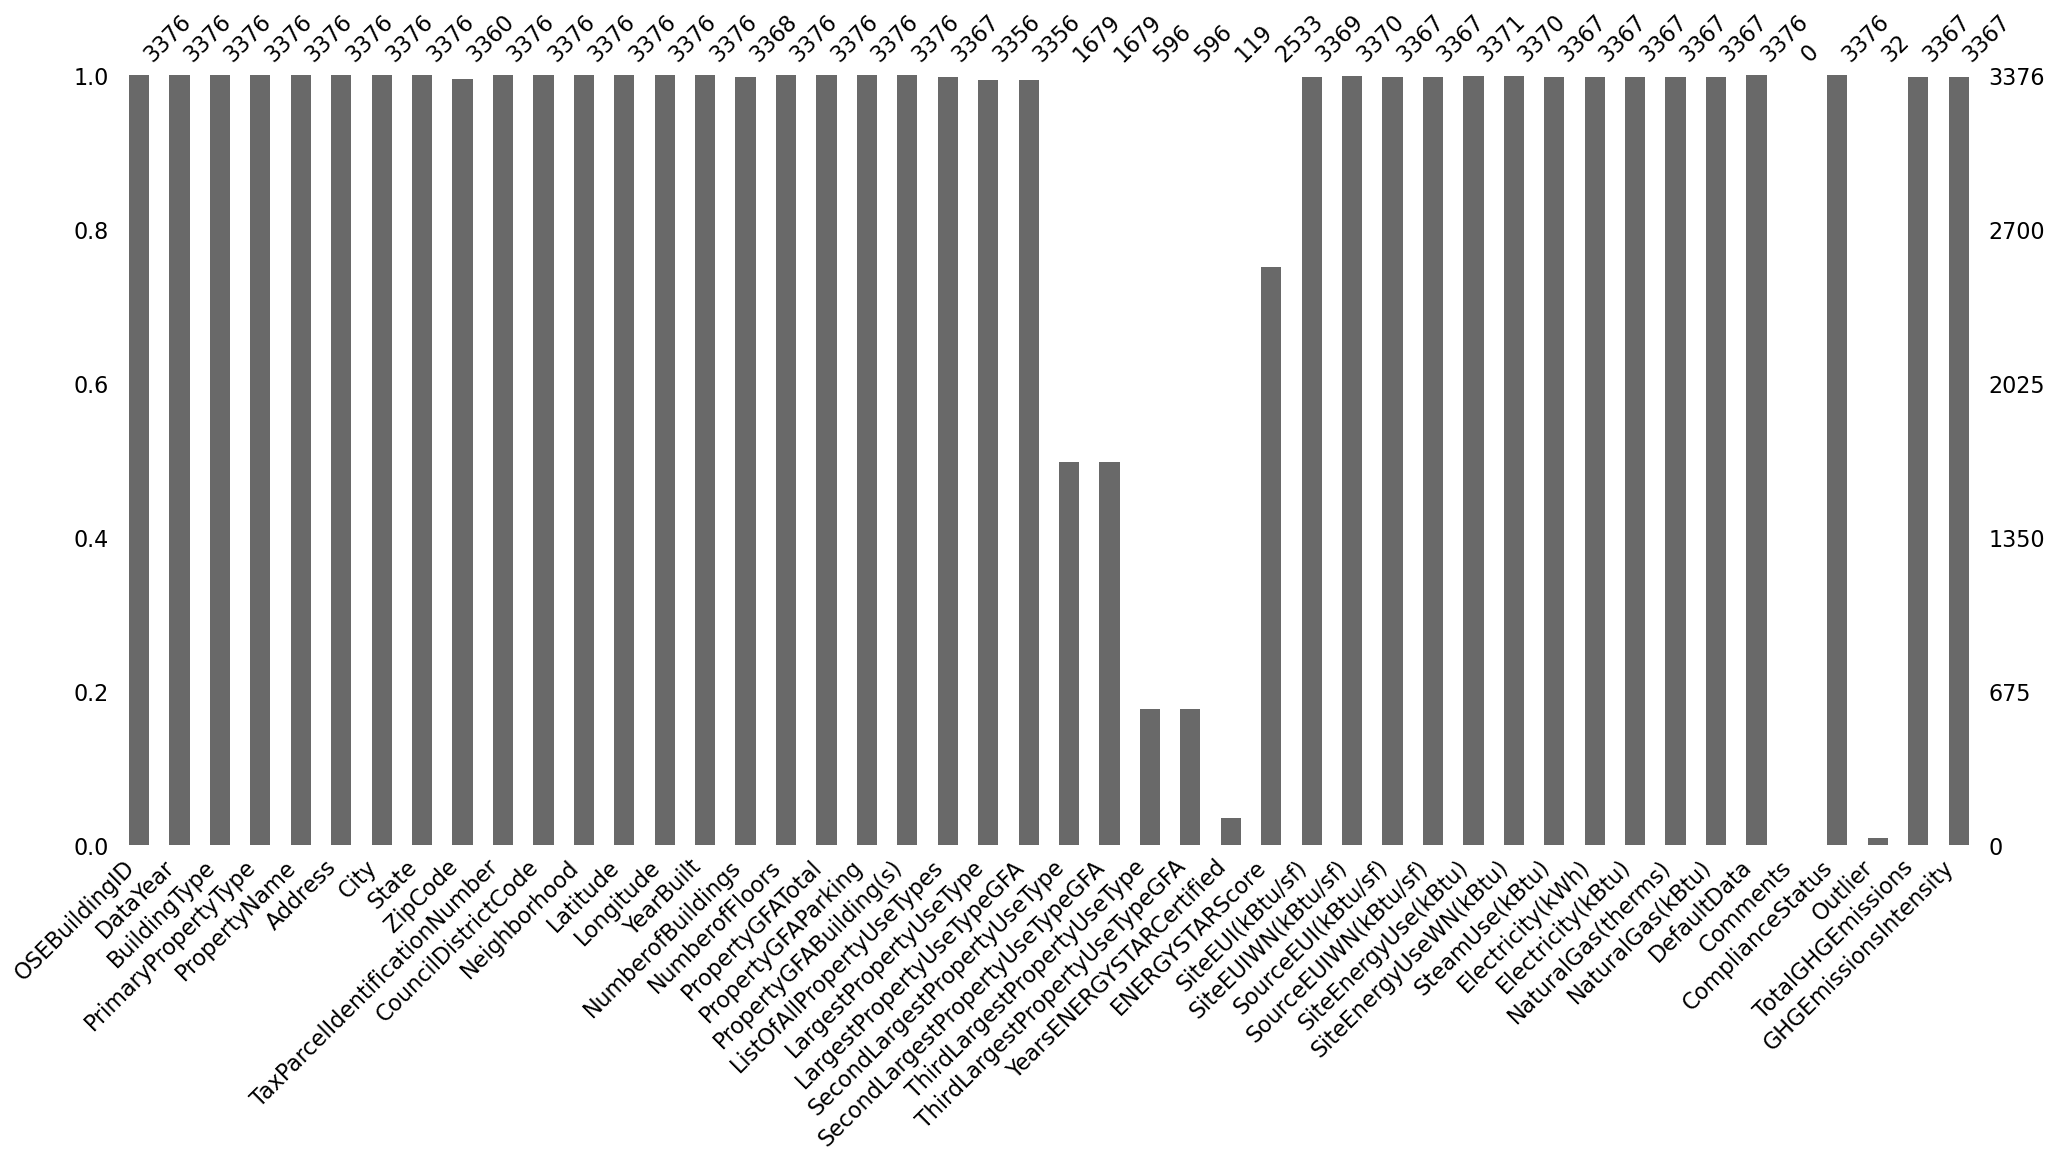

In [4]:
msno.bar(data)

### Descriptions interactives

In [26]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [27]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

In [29]:
@interact
def show_extract(column=list(data.columns)):
    tmp = data[column].value_counts()
    print(len(tmp))
    return data[column].value_counts().iloc[:20]

interactive(children=(Dropdown(description='column', options=('OSEBuildingID', 'DataYear', 'BuildingType', 'Pr…

# Mise en forme du dataset

In [8]:
t = ('int64', 'discrete', 'continue', 'nominal', 'ordinal')

In [9]:
for c in ['ZipCode', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 
          'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']:
    data[c] = data[c].astype('int64', errors='ignore')

In [10]:
COL = {'OSEBuildingID': ('string', 'nominal'),
       'DataYear':('int64', 'discrete'),
       'BuildingType':('category', ('string', 'nominal')),
       'PrimaryPropertyType':('category', ('string', 'nominal')),
       'PropertyName':('string', 'nominal'),
       'Address':('string', 'nominal'),
       'City':('category', ('string', 'nominal')),
       'State':('category', ('string', 'nominal')),
       'ZipCode':('category', ('string', 'nominal')),
       'TaxParcelIdentificationNumber':('string', 'nominal'),
       'CouncilDistrictCode':('category', ('string', 'nominal')),
       'Neighborhood':('category', ('string', 'nominal')),
       'Latitude':('float32', 'continue'),
       'Longitude':('float32', 'continue'),
       'YearBuilt':('int64', 'discrete'),
       'NumberofBuildings':('int64', 'discrete'),
       'NumberofFloors':('int64', 'discrete'),
       'PropertyGFATotal':('int64', 'discrete'),
       'PropertyGFAParking':('int64', 'discrete'),
       'PropertyGFABuilding(s)':('int64', 'discrete'),
       'ListOfAllPropertyUseTypes':('category', ('string', 'nominal')),
       'LargestPropertyUseType':('category', ('string', 'nominal')),
       'LargestPropertyUseTypeGFA':('int64', 'discrete'),
       'SecondLargestPropertyUseType':('category', ('string', 'nominal')),
       'SecondLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'ThirdLargestPropertyUseType':('category', ('string', 'nominal')),
       'ThirdLargestPropertyUseTypeGFA':('int64', 'discrete'),
       'YearsENERGYSTARCertified':('string', 'nominal'),
       'ENERGYSTARScore':('float32', 'continue'),
       'SiteEUI(kBtu/sf)':('float32', 'continue'),
       'SiteEUIWN(kBtu/sf)':('float32', 'continue'),
       'SourceEUI(kBtu/sf)':('float32', 'continue'),
       'SourceEUIWN(kBtu/sf)':('float32', 'continue'),
       'SiteEnergyUse(kBtu)':('float32', 'continue'),
       'SiteEnergyUseWN(kBtu)':('float32', 'continue'),
       'SteamUse(kBtu)':('float32', 'continue'),
       'Electricity(kWh)':('float32', 'continue'),
       'Electricity(kBtu)':('float32', 'continue'),
       'NaturalGas(therms)':('float32', 'continue'),
       'NaturalGas(kBtu)':('float32', 'continue'),
       'DefaultData':('boolean', 'nominal'),
       'Comments':('string', 'nominal'),
       'ComplianceStatus':('category', ('string', 'nominal')),
       'Outlier':('category', ('string', 'nominal')),
       'TotalGHGEmissions':('float32', 'continue'),
       'GHGEmissionsIntensity':('float32', 'continue')}

## Formatage de toutes les colonnes
### Changement du type

In [11]:
for c, e in COL.items():
    t, o = e
    if t == 'category':
        t, o = o
        data[c] = data[c].astype(t, errors='ignore')
        if t == 'string':
            data[c] = data[c].str.capitalize()
        data[c] = data[c].astype('category', errors='ignore')
    else:
        data[c] = data[c].astype(t, errors='ignore')
        if t == 'string':
            data[c] = data[c].str.capitalize()

## Créations de listes utiles

In [12]:
# Liste des colonnes à prédire (et leur nouveau nom)
col_Y =  ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
col_Y_rename = ['Energy', 'CO2']

# Liste des colonnes à ne pas utiliser car faisant partie des relevés
col_interdit = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', #'Outlier',
                'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments',
                'ComplianceStatus', 'GHGEmissionsIntensity']

col_inutile = ['DataYear', 'ListOfAllPropertyUseTypes', 'City', 'State', 'TaxParcelIdentificationNumber',
               'ListOfAllPropertyUseTypes', 'YearsENERGYSTARCertified']

In [13]:
def update_col(data, out=True):
    global col_nan, col_autorise, col_num, col_cat
    
    # Liste des colonnes avec plus de 50% de NaN
    col_nan = data.columns[data.isna().sum() > len(data)/2].to_list()

    # Inverse de la liste col_interdit et col_nan
    col_autorise = [e for e in data.columns if e not in col_interdit+col_nan+col_inutile]

    if out:
        #Ajout temperaire pour vérifier les outliers
        col_autorise += ['Outlier']

    # Liste des colonnes numeriques
    col_num = data[col_autorise].select_dtypes(include=['float', 'int']).columns.to_list()

    # Liste des colonnes categorielles
    col_cat = data[col_autorise].select_dtypes(include=['category']).columns.to_list()

In [14]:
update_col(data)

## Modification des valeurs
### Gestion des outliers

In [15]:
# Affichage des outliers selon les quantilles

@interact
def regarder_outliers(col = col_num):
    return data.loc[data[col] > data[col].mean() + 3 * data[col].std(), col_autorise].T

interactive(children=(Dropdown(description='col', options=('Latitude', 'Longitude', 'YearBuilt', 'NumberofBuil…

In [16]:
# Affichage des 5 valeurs les plus hautes

@interact
def regarder_outliers(col = col_num):
    return data.loc[data[col].sort_values(ascending=False).index[:5], col_autorise].T

interactive(children=(Dropdown(description='col', options=('Latitude', 'Longitude', 'YearBuilt', 'NumberofBuil…

In [17]:
# Modification des erreurs
data.loc[data['OSEBuildingID']=='21611', 'NumberofFloors'] = 1

### Remplacement des NaN

In [18]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].cat.add_categories('').fillna('')
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].cat.add_categories('').fillna('')
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].cat.add_categories('').fillna('')

In [19]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna(0)
data['SecondLargestPropertyUseTypeGFA'] = data['SecondLargestPropertyUseTypeGFA'].fillna(0)
data['ThirdLargestPropertyUseTypeGFA'] = data['ThirdLargestPropertyUseTypeGFA'].fillna(0)

### Création de nouvelles colonnes

In [20]:
# Colonnes de présence de certaines energies (puis conversion numerique)
data[['Steam', 'Electricity', 'Gas']] = data[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']] > 0
data[['Steam', 'Electricity', 'Gas']] = data[['Steam', 'Electricity', 'Gas']].replace({True: 1, False: 0})
data[['Steam', 'Electricity', 'Gas']] = data[['Steam', 'Electricity', 'Gas']].astype('int', errors='ignore')

In [32]:
def extract_street(address):
    # Parser l'adresse
    parsed_address = usaddress.parse(address)
    
    street = ""
    
    # Boucle à travers les composants de l'adresse pour trouver la rue
    for component in parsed_address:
        #if 'StreetName' in component[1]:
        if component[1] in ['StreetName', 'StreetNamePostType']:
            street += ' ' + component[0]
    street = street.replace('.', '')[1:]
    return street

In [33]:
# Colonne d'adresse plus simple (sans position ou numero)
data['SimpleAddress'] = data['Address'].apply(extract_street)
data['SimpleAddress'] = data['SimpleAddress'].astype('string', errors='ignore').astype('category', errors='ignore')

In [ ]:
# Nombre d'usages de la parcelle
# ListOfAllPropertyUseTypes -> nb de ,

In [ ]:
# Volume de surface entre 4 murs et un plafond 
# PropertyGFABuilding(s) * NumberofFloors

In [ ]:
# Viellesse
# 2023 - YearBuilt

In [ ]:
# Proximité à l'équateur (sin ?) [0 pole nord, 1 equateur]

In [ ]:
# Proximité à la mer (log)

In [ ]:
# Type de propriété selon PropertyName
# Extraire le dernier mot de PropertyName (enlever entre (), trim etc...)

In [ ]:
# Categories simplifies
# surface fermee, surface fermee pour humains, surface fermee pour stockage/machines, surface ouvertes
# calculer volume avec etages * surface

## Conversion des categories

In [23]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [24]:
update_col(data, out=False)

In [25]:
data[col_cat].isna().sum()

BuildingType                     0
ZipCode                         16
CouncilDistrictCode              0
Neighborhood                     0
LargestPropertyUseType           0
SecondLargestPropertyUseType     0
ThirdLargestPropertyUseType      0
SimpleAddress                    0
dtype: int64

In [26]:
# data['ZipCode'] = data['ZipCode'].cat.add_categories('').fillna('')

In [36]:
fill_zipcode = []

for i, z in fill_zipcode:
    data.loc[data['OSEBuildingID']==i, 'ZipCode'] = z

In [27]:
data[col_cat] = OrdinalEncoder().fit_transform(data[col_cat])

# Export des données

In [23]:
data = data.sample(frac=1)

In [24]:
update_col(data, out=False)

In [25]:
data_X_star = data[col_autorise].copy().dropna()
data_X = data[[e for e in col_autorise if e != 'ENERGYSTARScore']].copy().dropna()

data_Y_star = pd.DataFrame()
data_Y = pd.DataFrame()

data_Y_star[col_Y_rename] = data_X_star[col_Y].copy()
data_Y[col_Y_rename] = data_X[col_Y].copy()

data_X_star = data_X_star.drop(col_Y, axis=1)
data_X = data_X.drop(col_Y, axis=1)

In [31]:
import pickle

with open("./data/pickle", 'wb') as f:
    pickle.dump(([data_X, data_X_star], [data_Y, data_Y_star]), f)

# Visualisation

In [32]:
@interact
def show_extract(column=list(data.select_dtypes(include=['category', 'int']).columns)):
    tmp = data[column].value_counts().iloc[:30]

    plt.barh(list(tmp.index), tmp.values)

    plt.title("Nombre d'occurences pour {}".format(column))
    plt.ylabel("Nombre d'occurences")

    plt.show()

interactive(children=(Dropdown(description='column', options=('DataYear', 'PrimaryPropertyType', 'City', 'Stat…

In [33]:
data.select_dtypes(include=['float', 'int'])

,DataYear,BuildingType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Steam,Electricity,Gas,SimpleAddress
1426,2016,7.0,33.0,0.0,2.0,47.541759,-122.373489,1988,1.0,2,...,5.779831e+05,1972078.0,0.000000,0.0,13.750000,0.25,0,1,0,202.0
10,2016,4.0,11.0,6.0,4.0,47.606949,-122.334137,1969,1.0,11,...,1.813490e+06,6187627.0,45918.500000,4591850.0,691.260010,4.51,1,1,1,268.0
2702,2016,2.0,24.0,5.0,11.0,47.678860,-122.322998,1988,1.0,4,...,1.629506e+05,555987.0,120.459999,12046.0,4.520000,0.16,0,1,1,837.0
104,2016,4.0,30.0,2.0,5.0,47.614948,-122.321770,1915,1.0,3,...,5.601007e+05,1911064.0,11486.940430,1148694.0,74.330002,1.17,0,1,1,475.0
1481,2016,4.0,14.0,2.0,5.0,47.610741,-122.322594,1981,1.0,1,...,2.137741e+05,729397.0,0.000000,0.0,5.080000,0.24,0,1,0,613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,2016,3.0,38.0,2.0,1.0,47.599419,-122.310013,2008,1.0,6,...,5.873236e+05,2003948.0,0.000000,0.0,13.970000,0.16,0,1,0,917.0
2956,2016,2.0,19.0,6.0,8.0,47.627491,-122.349922,1963,1.0,4,...,1.390588e+05,474469.0,0.000000,0.0,3.310000,0.13,0,1,0,780.0
2796,2016,2.0,25.0,0.0,13.0,47.582119,-122.386108,2000,1.0,4,...,8.411560e+05,2870024.0,13459.669922,1345967.0,91.489998,1.19,0,1,1,405.0
2496,2016,3.0,25.0,0.0,13.0,47.594452,-122.388191,2000,1.0,5,...,1.084546e+05,370047.0,3972.760254,397276.0,23.680000,0.90,0,1,1,349.0


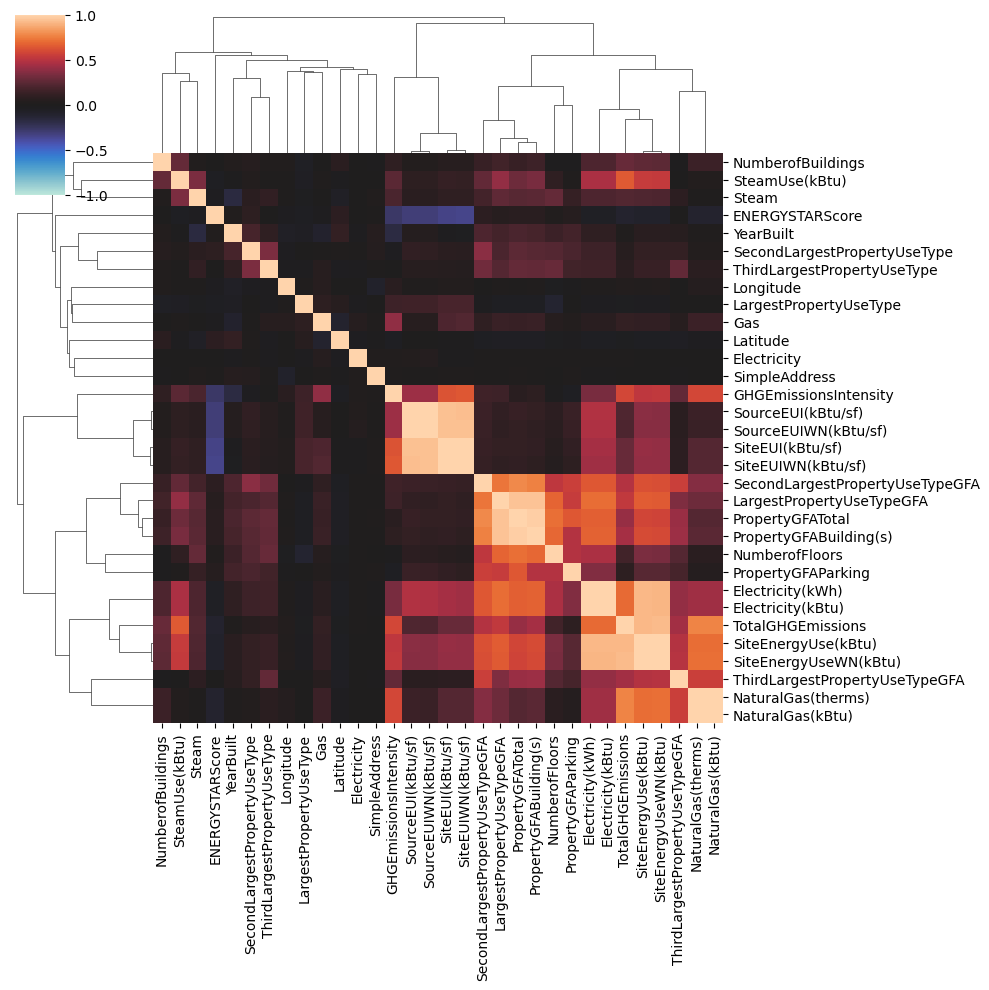

In [34]:
dataTmp = data.loc[:, 'Latitude':].select_dtypes(include=['float', 'int']).dropna().corr()
h = sns.clustermap(dataTmp, vmin=-1, vmax=1, center=0)

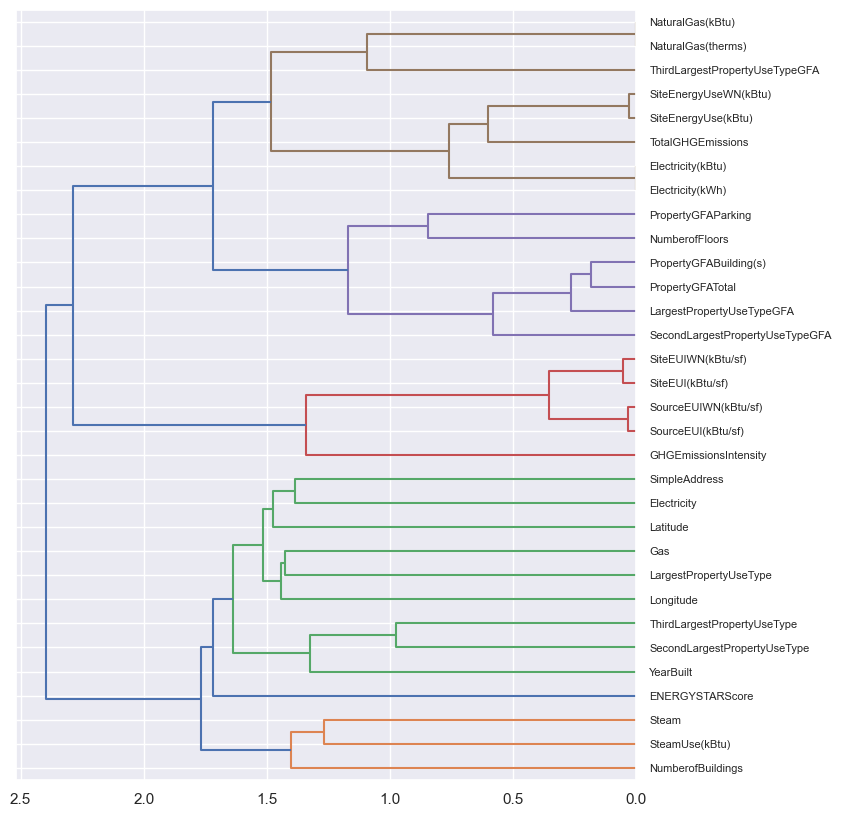

In [35]:
sns.set(rc={"figure.figsize":(8, 10)})
dendrogram(h.dendrogram_col.linkage, labels=dataTmp.columns, orientation='left');

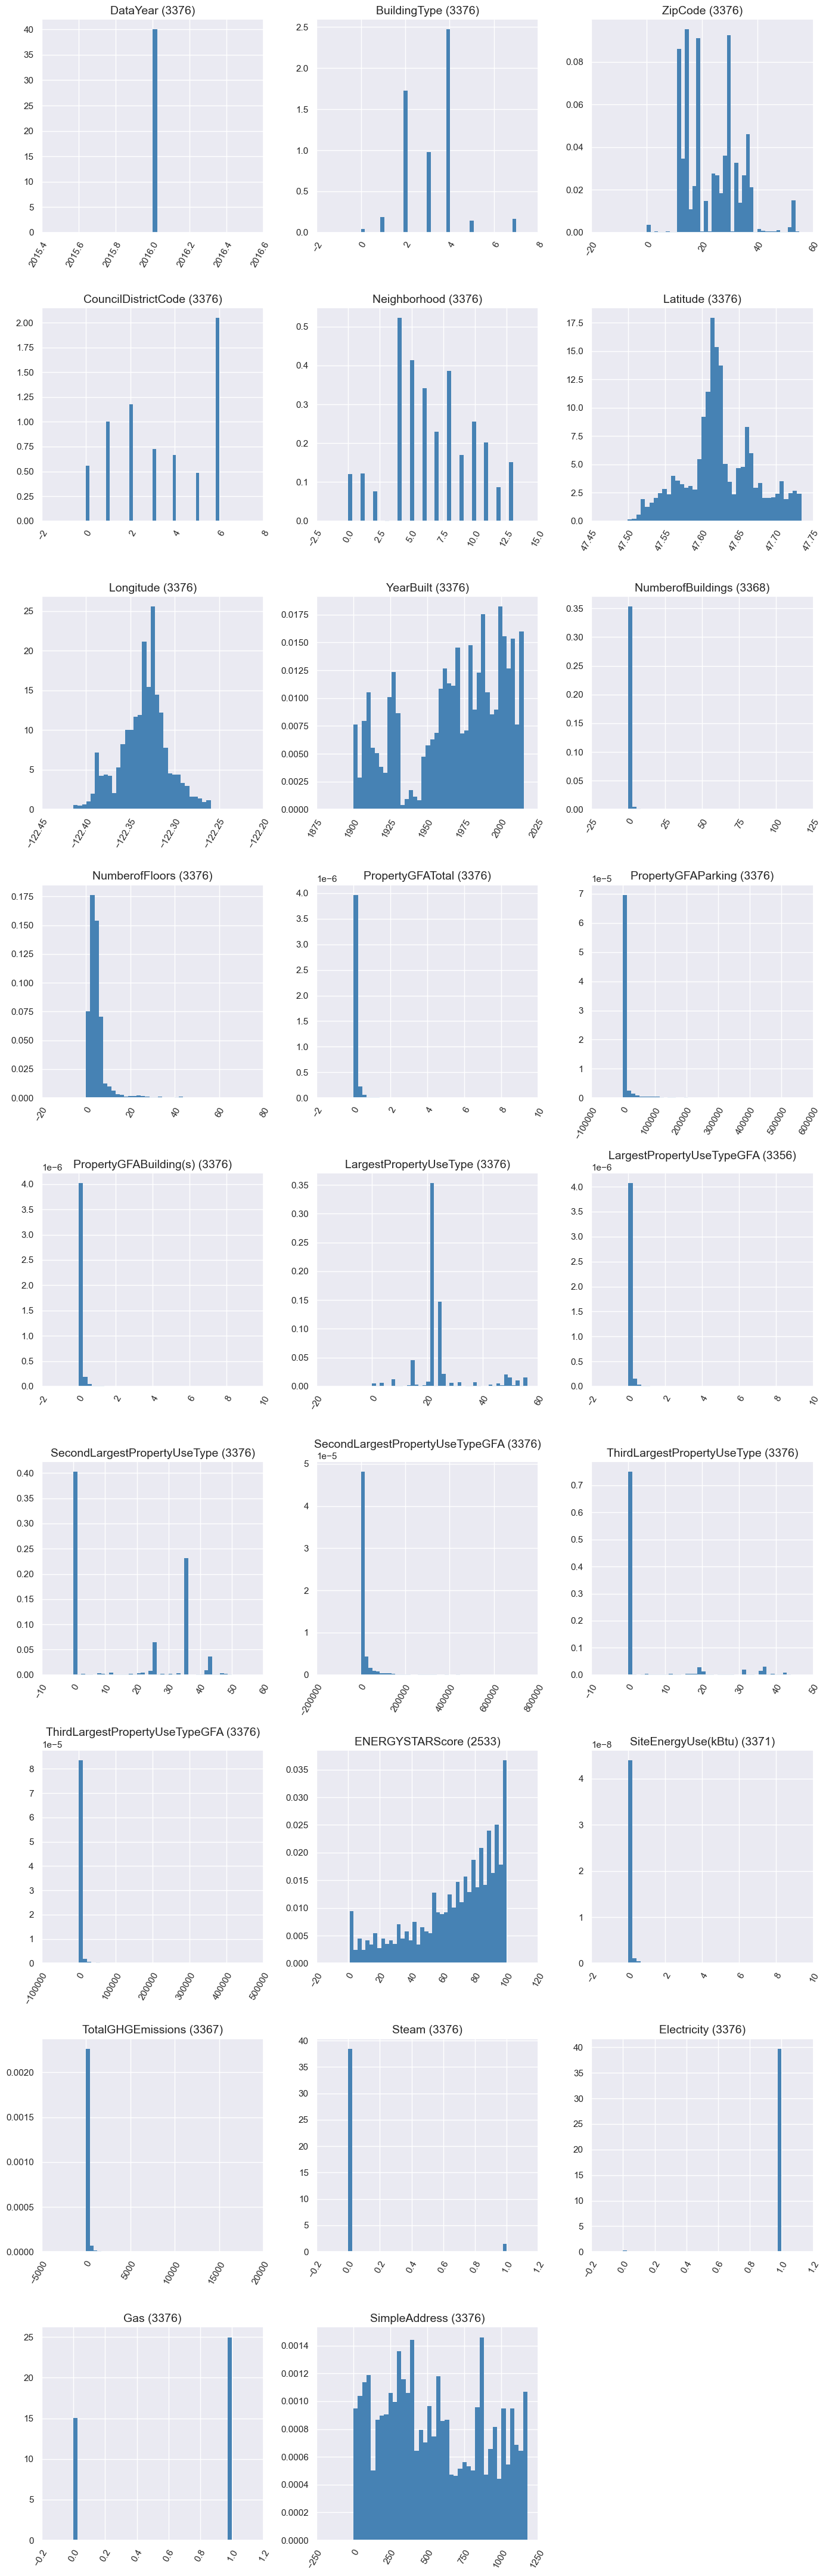

In [36]:
lTmp = list(data[col_autorise].select_dtypes(include=['category', 'int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.hist(tmp, bins=40, color='steelblue', density=True, edgecolor='none')
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    ax.set_xticks(ax.get_xticks(), [x.get_text()[:20] for x in ax.get_xticklabels()], rotation=60, ha='right', rotation_mode='anchor')

fig.tight_layout(pad=1)
plt.show()

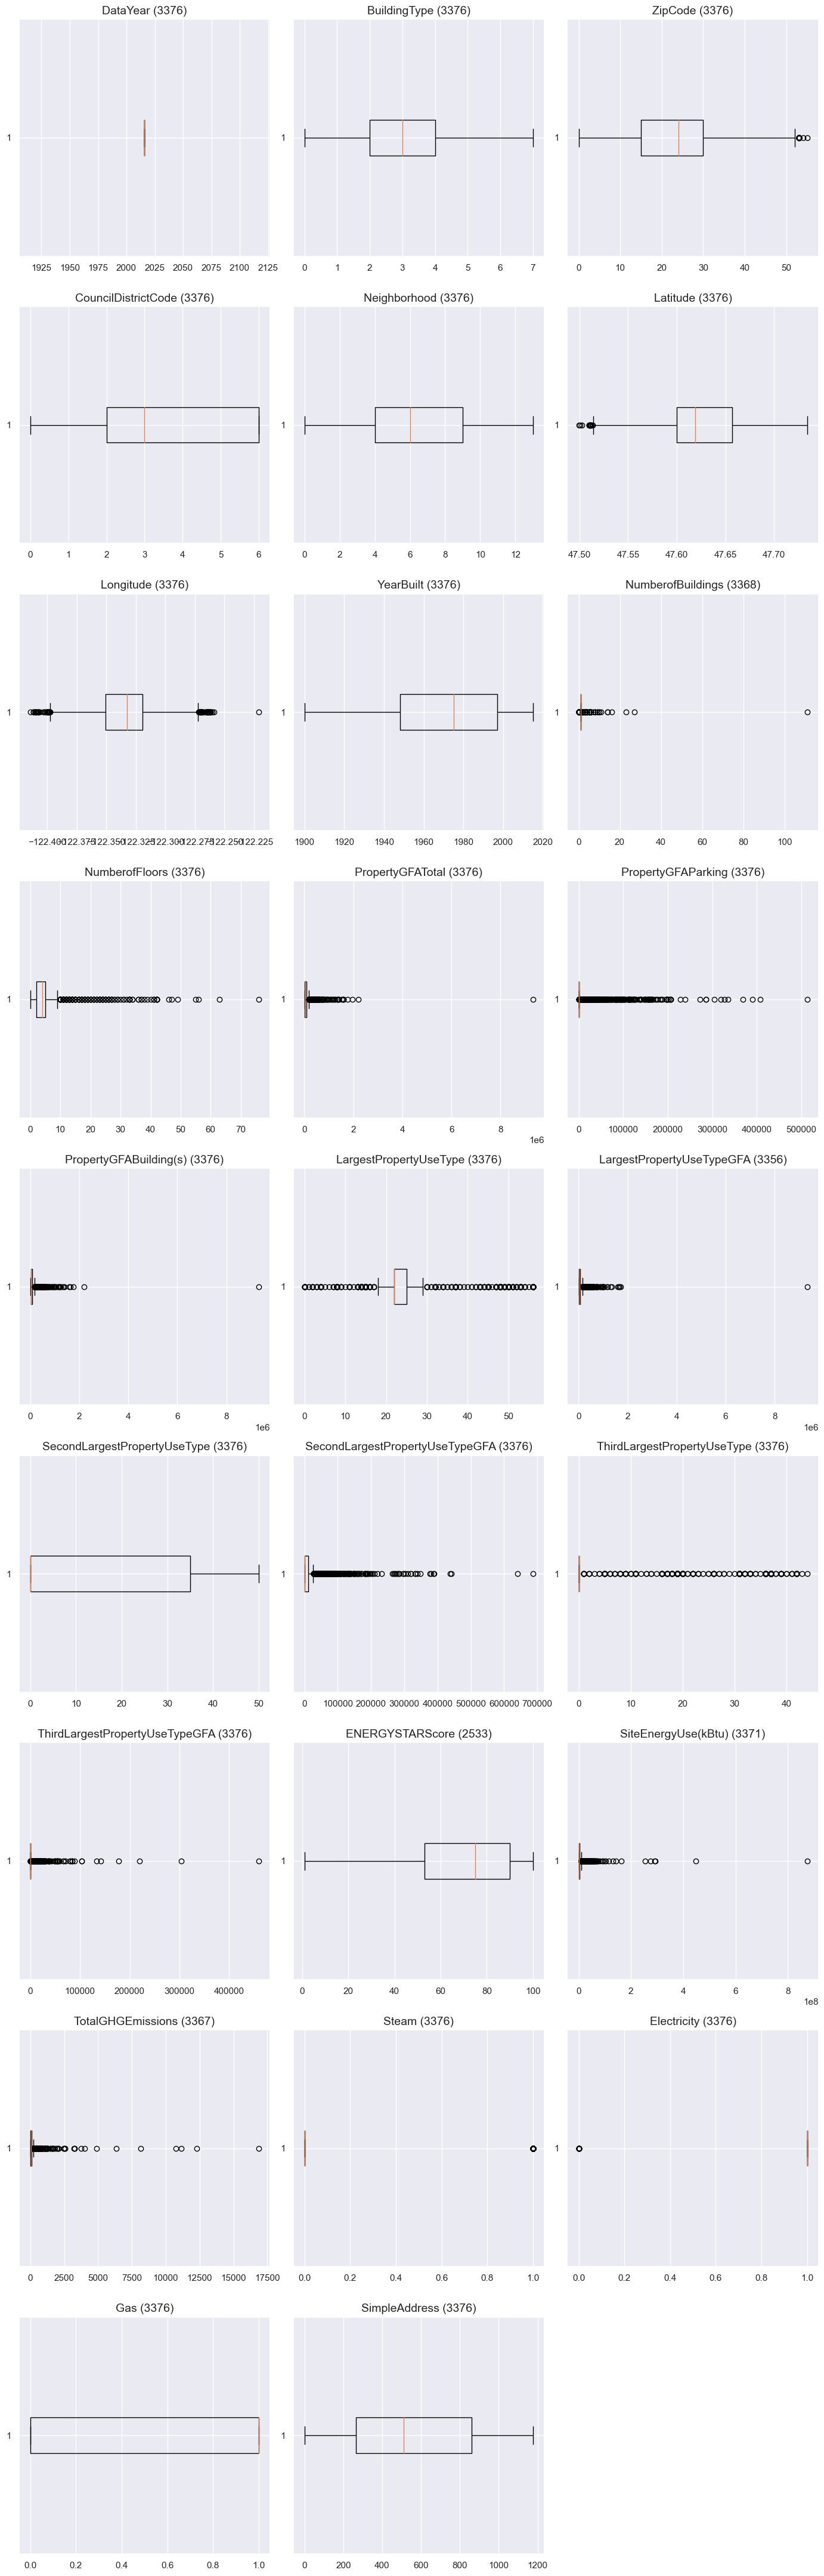

In [37]:
lTmp = list(data[col_autorise].select_dtypes(include=['int', 'float']).columns)
tTmp = len(lTmp)

fig = plt.figure(figsize=(14,  5 * tTmp/3))

for feat_idx in range(tTmp):
    ax = fig.add_subplot((2+tTmp)//3, 3, (feat_idx+1))
    
    tmp = data[lTmp[feat_idx]].dropna().copy()
    if tmp.dtype == 'category':
        tmp = tmp.loc[tmp.isin(tmp.value_counts()[:20].index)]
    
    h = ax.boxplot(tmp, vert=False)
    ax.set_title("{} ({})".format(lTmp[feat_idx], len(tmp)), fontsize=14)
    
fig.tight_layout(pad=1)
plt.show()

In [38]:
from math import *
from matplotlib.colors import LogNorm

In [39]:
sns.set(rc={"figure.figsize":(8, 6)})

@interact
def show_articles_more_than(couleur=data.select_dtypes(include=['int', 'float']).columns):
    x = data["Longitude"]
    y = data["Latitude"]

    c = data[couleur]

    fig = plt.figure()
    ax = plt.axes()
    
    if couleur in ['NumberofFloors', 'NumberofBuildings'] or '(' in couleur:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1, norm=LogNorm())
        ax.scatter(x, y, c=c, s=50, alpha=0.2, norm=LogNorm())
    else:
        sc = ax.scatter(x, y, c=c, s=0, alpha=1)
        ax.scatter(x, y, c=c, s=50, alpha=0.2)
        


    cb = fig.colorbar(sc, ax=ax)
    
    plt.show()

interactive(children=(Dropdown(description='couleur', options=('DataYear', 'BuildingType', 'ZipCode', 'Council…